In [1]:
import os
from pathlib import Path
import glob
import yaml
import h5py
import numpy as np
import scipy.signal as signal
from scipy.signal import resample
import matplotlib.pyplot as plt
import torch
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import TimeSeriesDict

from ml4gw.transforms import ChannelWiseScaler
from utils.filt import BandpassFilter

from train.data import DeepCleanDataset
from train.model import DeepClean
from train.architectures import Autoencoder
from train.metrics import PsdRatio
from train.metrics import OnlinePsdRatio

from clean.frames import FrameCrawler, frame_it, parse_frame_name
from clean.data import DeepCleanInferenceDataset
from clean.model import InferenceModel
from clean.infer import OnlineInference

%matplotlib inline

/home/chiajui.chou/.cache/pypoetry/virtualenvs/clean-IeYuvgpU-py3.10/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [30]:
data_prefix = f"/home/chiajui.chou/ll_data_O4_review"
data_dir = f"{data_prefix}/unresampled_data/H1"
hofts = glob.glob(f"{data_dir}/*llhoft*.gwf")
hofts = sorted(hofts)
wits = glob.glob(f"{data_dir}/*lldetchar*.gwf")
wits = sorted(wits)

clean_config_file = "/home/chiajui.chou/deepcleanv2/myprojects/60Hz-O3-MDC/config_clean.yaml"
with open(clean_config_file, 'r') as file:
    clean_config = yaml.safe_load(file)

train_dir = "/home/chiajui.chou/deepclean/results/train-O3-H1-kernel_1_1_st_0p5_epad_0p2_fpad_0p8_lr_0p2_oclr/lightning_logs/version_0"
train_config_file = f"{train_dir}/config.yaml"
with open(train_config_file, 'r') as file:
    train_config = yaml.safe_load(file)
train_hparams_file = f"{train_dir}/hparams.yaml"
with open(train_hparams_file, 'r') as file:
    train_hparams = yaml.safe_load(file)

In [8]:
hofts

[]

In [7]:
strain_source = hofts[0]
strain_channel = train_config['data']['channels'][0]
witness_channels = train_config['data']['channels'][1:]
witness_channels = sorted(witness_channels)
start, duration = 1250916844, 16
end = start + duration

strain = TimeSeries.read(
    source=strain_source,
    channel=strain_channel,
    start=start,
    end=end,
)
witness_source = wits[0]
witnesses = TimeSeriesDict.read(
    source=witness_source,
    channels=witness_channels,
    start=start,
    end=end,
)

IndexError: list index out of range

In [50]:
def gwpy_process(
        ts,
        start:float,
        end:float,
        resample_rate:float,
):
    copy = ts.copy()
    crop = copy.crop(start, end)
    output = crop.resample(resample_rate)
    return output

def scipy_process(
        ts,
        start:float,
        end:float,
        resample_rate:float,
        window:str,
):
    n = 60
    copy = ts.copy()
    crop = copy.crop(start, end)
    factor = (crop.sample_rate.value / resample_rate)
    # if factor.is_integer():
        # filt = signal.firwin(n+1, 1./factor, window=window)
        # out = signal.filtfilt(filt, [1.], crop.value)
        # return out[::int(factor)]
    if True:
        num = int(crop.duration.value * resample_rate)
        output = resample(
            x=crop.value,
            num=num,
            window=window,
        )
        return output

In [53]:
# print(f"original sample_rate: {strain.sample_rate}.")
resample_rate = 4096
start = strain.t0.value
# duration = strain.duration.value
duration = 3
end = start + duration
times = np.arange(start, end, 1/resample_rate)
window = 'boxcar'

ref_strain = gwpy_process(
    ts=strain,
    start=start,
    end=end,
    resample_rate=resample_rate,
)
print(f"sample_rate after resampled by gwpy: {ref_strain.sample_rate}.")
plt.figure(figsize=[10,3])
plt.plot(ref_strain.times, ref_strain)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.show()

sci_strain = scipy_process(
    ts=strain,
    start=start,
    end=end,
    resample_rate=resample_rate,
    window=window,
)
plt.figure(figsize=[10,3])
plt.plot(times, sci_strain)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.show()

NameError: name 'strain' is not defined

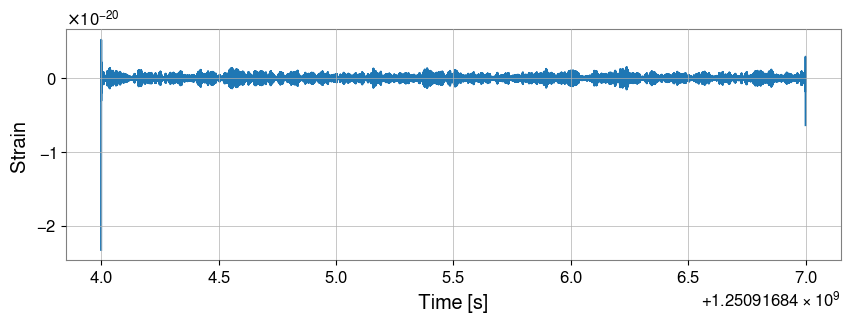

In [54]:
diff = ref_strain.value - sci_strain
plt.figure(figsize=[10,3])
plt.plot(times, diff)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.show()